# Задача классификации

## Постановка задачи
Множество классов $C = \{c_1, c_2, \ldots, c_n\}$.

Множество обучающих примеров $D_{train} = \{(X_i, y_i) | i = 1, 2, \ldots, N\}, y_i \in C, X_i \in \mathcal{X}$.

Требуется построить функцию $f: \mathcal{X} \to C$

## Бинарная классификация
Важный частный случай — два класса, $|C| = 2$. Часто классы обозначают как положительный и отрицательный (-1 и 1), или как 0 и 1.

### Оценка моделей бинарной классификации

Будем считать, что классы имеют метки 0 и 1

*TP (true positive)* - число объектов класса 1, предсказанных как 1

*FP (false positive)* - число объектов класса 0, предсказанных как 1

*TN (true negative)* - число объектов класса 0, предсказанных как 0

*FN (false negative)* - число объектов класса 1, предсказанных как 0

<table>
    <thead>
        <tr>
            <td>Истинная метка \ Предсказанная метка </td>
            <td>1</td>
            <td>0</td>
        </tr>
    </thead>
        <tr>
            <td>1</td>
            <td>TP</td>
            <td>FN</td>
        </tr>
    <tr>
            <td>0</td>
            <td>FP</td>
            <td>TN</td>
        </tr>
</table>


* **Accuracy** — доля верно предсказанных объектов
$$
     Accuracy = \frac{TP + TN}{TP + FP + FN + TN}
$$


* **Точность (precision)** — доля верно предсказанных объектов класса 1, среди всех объектов отмеченных первым классом
$$
    Precision = \frac{TP}{TP + FP}
$$


* **Полнота (recall)** — доля верно предсказанных объектов класса 1, среди всех объектов класса 1
$$
    Recall = \frac{TP}{TP + FN}
$$


* **F-мера (F-measure, так же F1-мера)** - среднее гармоническое между полнотой и точностью
$$
    F = 2\frac{Precision \cdot Recall}{Precision + Recall}
$$


* **Взвешенная $\beta$-F-мера** - среднее гармоническое между полнотой и точностью
$$
    F_{\beta} = (1 + \beta^2)\frac{2 Precision \cdot Recall}{\beta^2 Precision + Recall}
$$

Text(0.5, 1.0, 'Harmonic average')

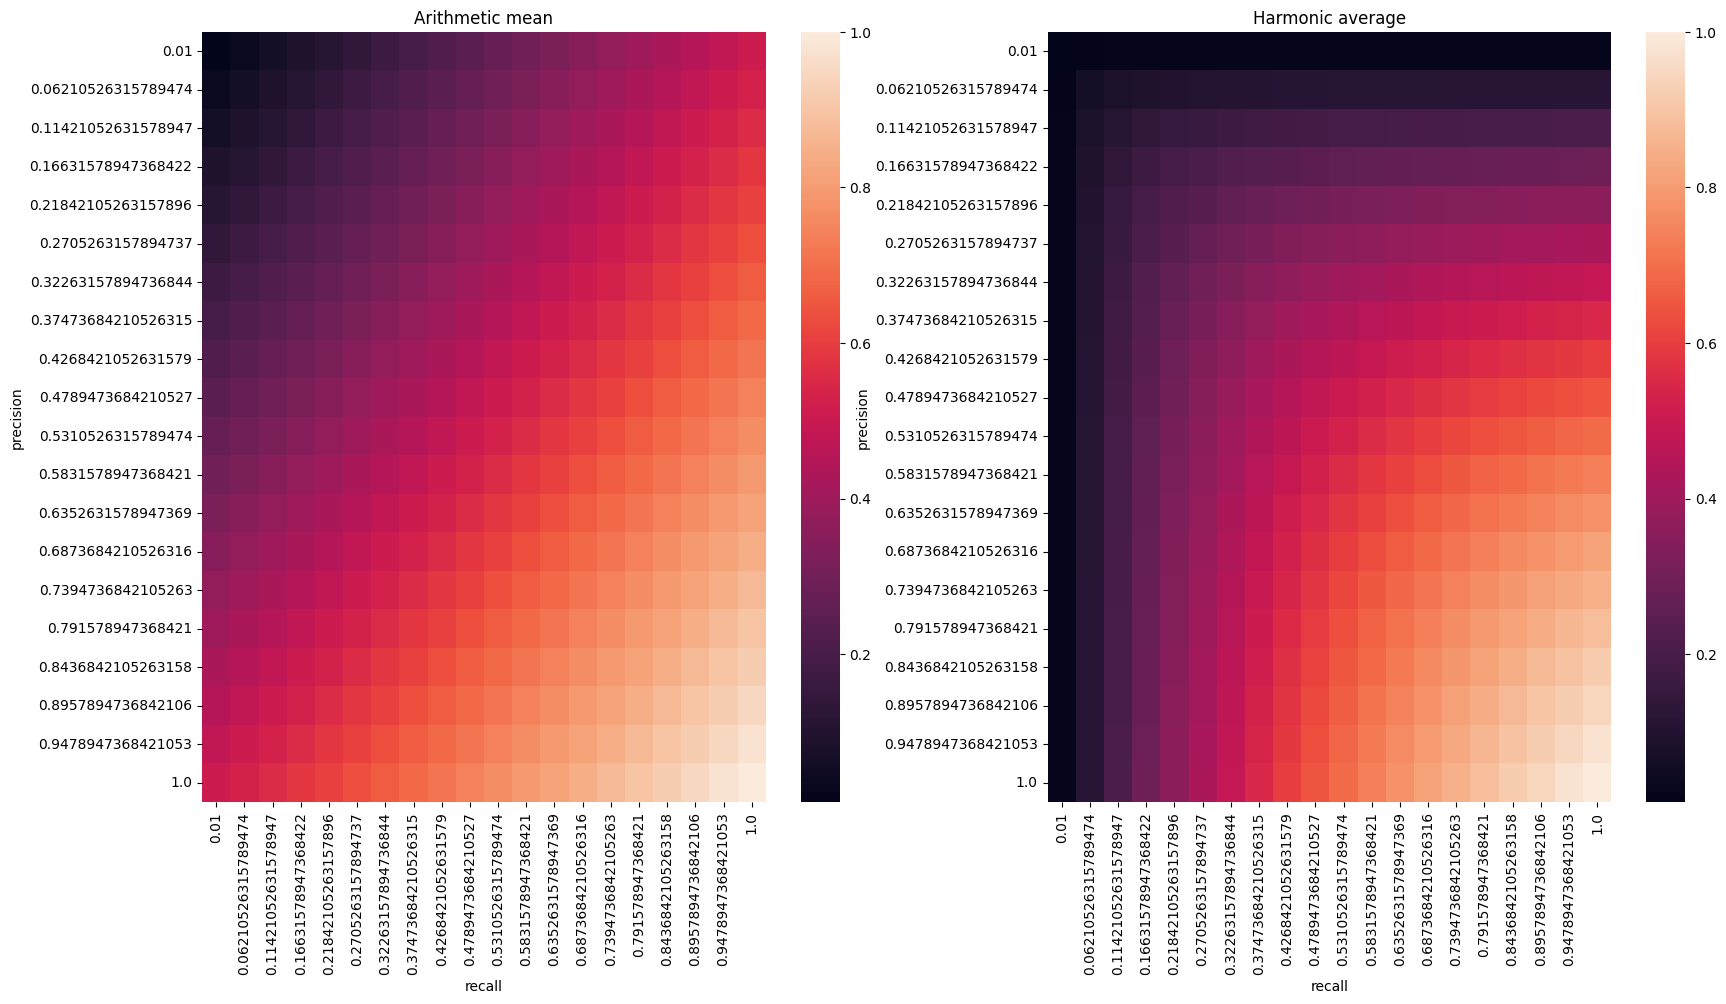

In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def avg(x, y):
    return (x + y) / 2


def harmonic(x, y):
    return 2 * x * y / (x + y)


range_ = np.linspace(0.01, 1, 20)

df = pd.DataFrame.from_records(
    {
        'precision': precision,
        'recall': recall,
        'avg': avg(precision, recall),
        'harmonic': harmonic(precision, recall)
    }
    for precision, recall in itertools.product(range_, range_)
)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.heatmap(
    df.pivot(index='precision', columns='recall', values='avg'), 
    ax=axes[0],
)

sns.heatmap(
    df.pivot(index='precision', columns='recall', values='harmonic'), 
    ax=axes[1],
)

axes[0].set_title('Arithmetic mean')
axes[1].set_title('Harmonic average')


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
y = np.array([0, 0, 1, 1])
scores = np.array([0.1, 0.4, 0.35, 0.8])

threshold = 0.3
print('Accuracy', accuracy_score(y, scores > threshold))
print('Precision', precision_score(y, scores > threshold))
print('Recall', recall_score(y, scores > threshold))


Accuracy 0.75
Precision 0.6666666666666666
Recall 1.0


#### ROC-кривая

*TPR — true positive rate*

*FPR - false positive rate* 

$$
    TPR = \frac{TP}{TP + FN} \\
    FPR = \frac{FP}{FP + TN}
$$

Давайте перебирать пороги и построем кривую в этих осях.

Эта криваая называется *Receiver operating characteristic*, а площадь под ней - ROC AUC
(AUC - area under curve)



**Вопрос.** Мы хотим постороить ROC кривую для конечного датасета. Можем ли мы это сделать точно за конечное время?



Можно доказать, что ROC AUC равен доле верно отражированных пар, где один объект из положительного класса, а второй — из отрицательного

Text(0.5, 1.0, 'Receiver operating characteristic AUC=0.75')

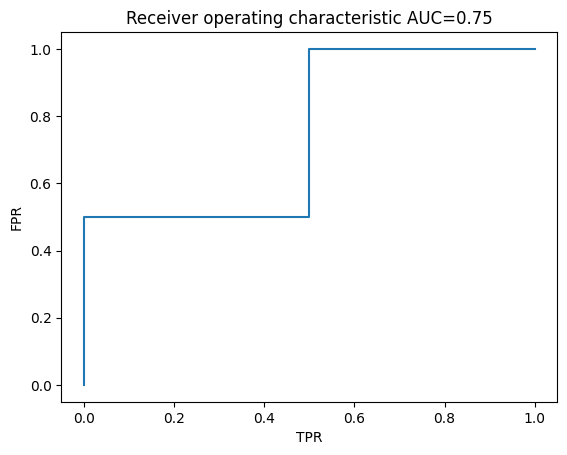

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve
y = np.array([0, 0, 1, 1])
scores = np.array([0.1, 0.4, 0.35, 0.8])

roc_auc_score_ = roc_auc_score(y, scores)
tpr, fpr, thresholds = roc_curve(y, scores)
plt.plot(tpr, fpr)
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title(f'Receiver operating characteristic AUC={roc_auc_score_}')

## Многоклассовая классификация
Будем предполагать, что классы — непересекаются.
Но вообще говоря, возможны и альтернативные постановки.

### Сведение многоклассой классификации к бинарной
####  Один против всех (one vs all)
Пусть есть $n$ классов. Обучим $n$ бинарных классификаторов, $k$-ый бинарный классификатоор обучен на выборке 
$$
    \{(X_i, y_i^k), i = 1, 2, \ldots, N\},
$$
где $y_i^k = \begin{cases}
    1, & \text{if } y_i = c_k, \\
    0, & \text{if } y_i \neq c_k
\end{cases}$

В качетсве итогого предсказания возьмем ответ от самого уверенного классификатора

Минусы:
- нужно строить $n$ классификаторов
- классификаторы могут выдавать предсказания в разных масштабах

#### Все против всех
Обучем $C_n^{2}$ попарных классификаторов для каждой пары классов $(c_i, c_j), 1 \leq i < j \leq n$.
$k$-ый классификатор обучается на подвыборке исходной обучающей выборке, полученной фильрацией по условию что объект лежит либо в $i$-ом классе, либо в $j$-ом.
$$
    D_{train}^k = \left\{(X, y) \in D_{train} | y \in \{c_i, c_j\}\right\}
$$

Для получения предсказаний, каждый из классификаторов голосует за один из двух классов.
После чего итоговое предсказание может быть получено как класс, за который было отдано наибольшее число голосов.

Минусы:
- вычислительно затратно
- ничьи в результате голосования

### Модификация метода обучения
На примере логистической регрессии


#### Softmax
Пусть есть $n$ чисел, каждое из которых можно интерпретировать как предсказания классификатора о принадлежности объекта соответствующему классу. Мы хотим перенормировать их таким образом, чтобы получить вероятностное распредление.
$$
   Softmax(x_1, x_2, \ldots, x_n) = \left(
       \frac{e^{x_1}}{\sum_{j=1}^n e^{x_j}},
       \frac{e^{x_2}}{\sum_{j=1}^n e^{x_j}},
       \frac{e^{x_3}}{\sum_{j=1}^n e^{x_j}},
       \ldots, 
       \frac{e^{x_n}}{\sum_{j=1}^n e^{x_j}}
   \right)
$$


#### Кросс-энтропия
Если выборка сгенерирована из случайного дискретного распредления, то правдоподобие может быть записано формуле
$$
    LH = \prod_{i=1}^n P(y=y_i| X_i).
$$

Логарифмируя и раскрывая $Softmax$, получаем
$$
    LLH = \sum\limits_{i=1}^n \ln P(y=y_i| X_i) = \sum\limits_{i=1}^n (a_{y_i}(X) - \ln \sum_{j=1}^n e^{a_j(X)})
$$

Это выражение со знаком минус называется *кросс-энтропией*

### Метрики многоклассовой классификации
Accuracy можно считать без изменений.

#### Precision и Recall
Что можно сделать с Precision и Recall?

1. Посчитать по каждому классу и усреднить по всем классам. **Macro-average**
1. Посчитать по всему датасету TP, FP, FN и сооставить соотношение. **Micro-average**

$$
    MicroPrecision = \frac{TP_A + TP_B + \ldots TP_N}{TP_A + FP_A + \ldots + TP_N + FP_N} \\
    MicroRecall = \frac{TP_A + TP_B + \ldots TP_N}{TP_A + FN_A + \ldots + TP_N + FN_N}
$$

**Упраженение.** Покажите, что $MicroPrecision = MicroRecall.$

3. Можно при усреденение домножать на число элементов в классе. **Weighted**